In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
import wandb
from wandb.keras import WandbCallback

from __future__ import absolute_import
from __future__ import print_function

import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import time


# from keras.models import Model
# from keras.layers import Input, Flatten, Dense, Dropout, Lambda
# from keras.optimizers import RMSprop
# from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from skimage.transform import resize
from sklearn.manifold import TSNE

In [ ]:
#tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)
np.random.seed(0)

In [ ]:
wandb.login(key="204401a4f4dd559f72b4a05d951003a500c49d55")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
num_classes = 268
epochs = 80

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, cattle_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(cattle_indices[d]) for d in range(num_classes)]) - 1
    #print(n)
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = cattle_indices[d][i], cattle_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            random.seed(0) # This ensures repeatibility. For some strange reason, setting this at the beginning doesn't work
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = cattle_indices[d][i], cattle_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < threshold
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
# load training data
path = '/content/drive/MyDrive/CapStone/data/NPY_OG_FULL'
train = np.load(f"{path}/train_sch.npy")
labels_train = np.load(f"{path}/labels_train_sch.npy")

In [ ]:
# load validation data
valid = np.load(f"{path}/valid_sch.npy")
labels_valid = np.load(f"{path}/labels_valid_sch.npy")

In [ ]:
# load  datatest
test = np.load(f"{path}/test_sch.npy")
labels_test = np.load(f"{path}/labels_test_sch.npy")

## Transform Train, Valid and Test Images to Grayscale

In [ ]:
# Initialize an empty array for the grayscale images
import cv2
gray_train_images = np.empty((train.shape[0], 50, 50))
gray_valid_images = np.empty((valid.shape[0], 50, 50))
gray_test_images = np.empty((test.shape[0], 50, 50))

# Convert each image to grayscale
for i in range(train.shape[0]):
    gray = cv2.cvtColor(train[i].astype(np.float32), cv2.COLOR_RGB2GRAY)
    gray_train_images[i] = gray

for i in range(valid.shape[0]):
    gray = cv2.cvtColor(valid[i].astype(np.float32), cv2.COLOR_RGB2GRAY)
    gray_valid_images[i] = gray

for i in range(test.shape[0]):
    gray = cv2.cvtColor(test[i].astype(np.float32), cv2.COLOR_RGB2GRAY)
    gray_test_images[i] = gray

train = gray_train_images
valid = gray_valid_images
test = gray_test_images

## Final Preprocessing of Images

In [ ]:
# sort the entire data
idx_train = np.argsort(labels_train)
idx_test = np.argsort(labels_test)
idx_valid = np.argsort(labels_valid)

# sort training set
train = train[idx_train]
labels_train = labels_train[idx_train]
test = test[idx_test]
labels_test = labels_test[idx_test]
valid = valid[idx_valid]
labels_valid = labels_valid[idx_valid]

In [ ]:
train = train.astype('float32')
valid = valid.astype('float32')
train /= 255
valid /= 255
test = test/255
input_shape = train.shape[1:]

In [ ]:
# Define unique
unique = np.unique(labels_train)

## Define HyperParams

In [ ]:
config = {
    "batch_size": 32, # restore to 4 later
    "optimizer": "RMSProp"
}

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    name = "final-run",
    project="Capstone-Siamese",
    reinit = True,

    # track hyperparameters and run metadata
    config=config
)


wandb: Currently logged in as: lnkama (dl-cmu). Use `wandb login --relogin` to force relogin


## Perform Training

In [ ]:
x_train = train.copy()
y_train = labels_train.copy()
x_valid = valid.copy()
y_valid = labels_valid.copy()
x_test = test.copy()
y_test = labels_test.copy()

In [ ]:
# create training+test positive and negative pairs
cattle_indices = [np.where(y_train == i)[0] for i in unique]
tr_pairs, tr_y = create_pairs(x_train, cattle_indices, 268)
cattle_indices = [np.where(y_valid == i)[0] for i in unique]
tv_pairs, tv_y = create_pairs(x_valid, cattle_indices, 268)
tv_pairs.shape

(3752, 2, 50, 50)

In [ ]:
checkpoint = ModelCheckpoint('model-best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Add the checkpoint to the list of callbacks
callbacks_list = [checkpoint, WandbCallback(save_model=True)]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
# network definition
#tf.random.set_seed(0)

base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
#rms = Adam()
#rms = SGD()

model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# train
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y.astype(np.float32), # why float32
          batch_size=config["batch_size"], # original is 128
          epochs=epochs,
          validation_data=([tv_pairs[:, 0], tv_pairs[:, 1]], tv_y.astype(np.float32)), callbacks=callbacks_list) # why float32



# compute final accuracy on training and validation sets using the best model
model = load_model('model-best.h5', custom_objects={'contrastive_loss': contrastive_loss })
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_tv = model.predict([tv_pairs[:, 0], tv_pairs[:, 1]])
tv_acc = compute_accuracy(tv_y, y_pred_tv)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on val set: %0.2f%%' % (100 * tv_acc))

Epoch 1/80
499/503 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.6520
Epoch 1: val_loss improved from inf to 0.20920, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 6s 9ms/step - loss: 0.2106 - accuracy: 0.6527 - val_loss: 0.2092 - val_accuracy: 0.6610
Epoch 2/80
499/503 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.8126
Epoch 2: val_loss improved from 0.20920 to 0.09996, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.1403 - accuracy: 0.8123 - val_loss: 0.1000 - val_accuracy: 0.8689
Epoch 3/80
499/503 [============================>.] - ETA: 0s - loss: 0.1220 - accuracy: 0.8414
Epoch 3: val_loss did not improve from 0.09996
503/503 [==============================] - 3s 6ms/step - loss: 0.1221 - accuracy: 0.8408 - val_loss: 0.1219 - val_accuracy: 0.8268
Epoch 4/80
499/503 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.8510
Epoch 4: val_loss improved from 0.09996 to 0.08895, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.1145 - accuracy: 0.8506 - val_loss: 0.0890 - val_accuracy: 0.8872
Epoch 5/80
499/503 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.8685
Epoch 5: val_loss did not improve from 0.08895
503/503 [==============================] - 3s 6ms/step - loss: 0.1044 - accuracy: 0.8688 - val_loss: 0.0953 - val_accuracy: 0.8641
Epoch 6/80
499/503 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.8749
Epoch 6: val_loss improved from 0.08895 to 0.08270, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.1005 - accuracy: 0.8751 - val_loss: 0.0827 - val_accuracy: 0.8906
Epoch 7/80
495/503 [============================>.] - ETA: 0s - loss: 0.0940 - accuracy: 0.8843
Epoch 7: val_loss did not improve from 0.08270
503/503 [==============================] - 3s 6ms/step - loss: 0.0940 - accuracy: 0.8842 - val_loss: 0.1055 - val_accuracy: 0.8551
Epoch 8/80
503/503 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.8926
Epoch 8: val_loss did not improve from 0.08270
503/503 [==============================] - 3s 6ms/step - loss: 0.0883 - accuracy: 0.8926 - val_loss: 0.0970 - val_accuracy: 0.8694
Epoch 9/80
497/503 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.8981
Epoch 9: val_loss improved from 0.08270 to 0.08219, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0849 - accuracy: 0.8985 - val_loss: 0.0822 - val_accuracy: 0.8930
Epoch 10/80
497/503 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9056
Epoch 10: val_loss improved from 0.08219 to 0.08054, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0809 - accuracy: 0.9062 - val_loss: 0.0805 - val_accuracy: 0.8994
Epoch 11/80
501/503 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9125
Epoch 11: val_loss improved from 0.08054 to 0.06696, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0770 - accuracy: 0.9123 - val_loss: 0.0670 - val_accuracy: 0.9200
Epoch 12/80
495/503 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9174
Epoch 12: val_loss did not improve from 0.06696
503/503 [==============================] - 3s 6ms/step - loss: 0.0736 - accuracy: 0.9175 - val_loss: 0.0721 - val_accuracy: 0.9142
Epoch 13/80
501/503 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9240
Epoch 13: val_loss improved from 0.06696 to 0.06504, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 5s 9ms/step - loss: 0.0702 - accuracy: 0.9238 - val_loss: 0.0650 - val_accuracy: 0.9298
Epoch 14/80
501/503 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9282
Epoch 14: val_loss did not improve from 0.06504
503/503 [==============================] - 3s 6ms/step - loss: 0.0674 - accuracy: 0.9283 - val_loss: 0.0685 - val_accuracy: 0.9160
Epoch 15/80
497/503 [============================>.] - ETA: 0s - loss: 0.0669 - accuracy: 0.9277
Epoch 15: val_loss did not improve from 0.06504
503/503 [==============================] - 3s 6ms/step - loss: 0.0667 - accuracy: 0.9280 - val_loss: 0.0698 - val_accuracy: 0.9174
Epoch 16/80
497/503 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9331
Epoch 16: val_loss did not improve from 0.06504
503/503 [==============================] - 3s 6ms/step - loss: 0.0636 - accuracy: 0.9333 - val_loss: 0.0687 - val_accuracy: 0.9163
Epoch 17/80
503/503 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0617 - accuracy: 0.9351 - val_loss: 0.0641 - val_accuracy: 0.9227
Epoch 18/80
500/503 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9383
Epoch 18: val_loss did not improve from 0.06411
503/503 [==============================] - 3s 6ms/step - loss: 0.0607 - accuracy: 0.9385 - val_loss: 0.0690 - val_accuracy: 0.9129
Epoch 19/80
496/503 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9408
Epoch 19: val_loss did not improve from 0.06411
503/503 [==============================] - 3s 6ms/step - loss: 0.0586 - accuracy: 0.9405 - val_loss: 0.0718 - val_accuracy: 0.9171
Epoch 20/80
495/503 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9431
Epoch 20: val_loss did not improve from 0.06411
503/503 [==============================] - 3s 6ms/step - loss: 0.0562 - accuracy: 0.9432 - val_loss: 0.0679 - val_accuracy: 0.9200
Epoch 21/80
501/503 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0546 - accuracy: 0.9454 - val_loss: 0.0577 - val_accuracy: 0.9354
Epoch 22/80
502/503 [============================>.] - ETA: 0s - loss: 0.0534 - accuracy: 0.9473
Epoch 22: val_loss did not improve from 0.05771
503/503 [==============================] - 3s 7ms/step - loss: 0.0534 - accuracy: 0.9474 - val_loss: 0.0597 - val_accuracy: 0.9303
Epoch 23/80
503/503 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9478
Epoch 23: val_loss improved from 0.05771 to 0.05347, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 9ms/step - loss: 0.0529 - accuracy: 0.9478 - val_loss: 0.0535 - val_accuracy: 0.9399
Epoch 24/80
502/503 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9496
Epoch 24: val_loss did not improve from 0.05347
503/503 [==============================] - 3s 6ms/step - loss: 0.0521 - accuracy: 0.9496 - val_loss: 0.0559 - val_accuracy: 0.9444
Epoch 25/80
502/503 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9516
Epoch 25: val_loss did not improve from 0.05347
503/503 [==============================] - 3s 6ms/step - loss: 0.0501 - accuracy: 0.9515 - val_loss: 0.0692 - val_accuracy: 0.9184
Epoch 26/80
500/503 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9532
Epoch 26: val_loss improved from 0.05347 to 0.04962, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0492 - accuracy: 0.9532 - val_loss: 0.0496 - val_accuracy: 0.9462
Epoch 27/80
501/503 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9546
Epoch 27: val_loss did not improve from 0.04962
503/503 [==============================] - 3s 6ms/step - loss: 0.0474 - accuracy: 0.9546 - val_loss: 0.0508 - val_accuracy: 0.9423
Epoch 28/80
501/503 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9562
Epoch 28: val_loss did not improve from 0.04962
503/503 [==============================] - 3s 6ms/step - loss: 0.0466 - accuracy: 0.9561 - val_loss: 0.0612 - val_accuracy: 0.9309
Epoch 29/80
501/503 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9537
Epoch 29: val_loss did not improve from 0.04962
503/503 [==============================] - 3s 6ms/step - loss: 0.0469 - accuracy: 0.9537 - val_loss: 0.0601 - val_accuracy: 0.9301
Epoch 30/80
502/503 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0359 - accuracy: 0.9686 - val_loss: 0.0483 - val_accuracy: 0.9449
Epoch 44/80
502/503 [============================>.] - ETA: 0s - loss: 0.0346 - accuracy: 0.9702
Epoch 44: val_loss did not improve from 0.04825
503/503 [==============================] - 3s 6ms/step - loss: 0.0347 - accuracy: 0.9700 - val_loss: 0.0553 - val_accuracy: 0.9325
Epoch 45/80
495/503 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9698
Epoch 45: val_loss did not improve from 0.04825
503/503 [==============================] - 3s 6ms/step - loss: 0.0336 - accuracy: 0.9698 - val_loss: 0.0485 - val_accuracy: 0.9441
Epoch 46/80
495/503 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9704
Epoch 46: val_loss improved from 0.04825 to 0.04742, saving model to model-best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 8ms/step - loss: 0.0336 - accuracy: 0.9706 - val_loss: 0.0474 - val_accuracy: 0.9460
Epoch 47/80
501/503 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9709
Epoch 47: val_loss did not improve from 0.04742
503/503 [==============================] - 3s 6ms/step - loss: 0.0333 - accuracy: 0.9710 - val_loss: 0.0538 - val_accuracy: 0.9372
Epoch 48/80
498/503 [============================>.] - ETA: 0s - loss: 0.0325 - accuracy: 0.9713
Epoch 48: val_loss did not improve from 0.04742
503/503 [==============================] - 3s 6ms/step - loss: 0.0326 - accuracy: 0.9710 - val_loss: 0.0567 - val_accuracy: 0.9333
Epoch 49/80
502/503 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9727
Epoch 49: val_loss did not improve from 0.04742
503/503 [==============================] - 3s 6ms/step - loss: 0.0323 - accuracy: 0.9727 - val_loss: 0.0575 - val_accuracy: 0.9333
Epoch 50/80
496/503 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231205_034633-tm22zvel/files/model-best)... Done. 0.0s


503/503 [==============================] - 4s 9ms/step - loss: 0.0267 - accuracy: 0.9753 - val_loss: 0.0465 - val_accuracy: 0.9436
Epoch 69/80
496/503 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9776
Epoch 69: val_loss did not improve from 0.04654
503/503 [==============================] - 3s 6ms/step - loss: 0.0255 - accuracy: 0.9778 - val_loss: 0.0498 - val_accuracy: 0.9417
Epoch 70/80
500/503 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9764
Epoch 70: val_loss did not improve from 0.04654
503/503 [==============================] - 3s 6ms/step - loss: 0.0255 - accuracy: 0.9765 - val_loss: 0.0554 - val_accuracy: 0.9362
Epoch 71/80
501/503 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9765
Epoch 71: val_loss did not improve from 0.04654
503/503 [==============================] - 3s 6ms/step - loss: 0.0252 - accuracy: 0.9766 - val_loss: 0.0494 - val_accuracy: 0.9436
Epoch 72/80
497/503 [====================

In [ ]:
uniq, count = np.unique(labels_train, return_counts=True)
count

array([31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31

In [ ]:
np.sum(count[:104])

3224

In [ ]:
# Compute final accuracy on test set
cattle_indices = [np.where(y_test == i)[0] for i in unique]
te_pairs, te_y = create_pairs(x_test, cattle_indices, 268)
pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
acc = compute_accuracy(te_y, pred_te)
print(f"Test accuracy is: {acc}")

67/67 [==============================] - 0s 3ms/step
Test accuracy is: 0.9272388059701493


In [ ]:
# Log the test accuracy to wandb
wandb.log({f'Test Accuracy': acc})

## Compute EER for different thresholds

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cattle_indices = [np.where(y_test == i)[0] for i in unique]
fars = []
frrs = []

for i in range(len(thresholds)):
  # for each threshold, create a new pair for test set
  pairs, y = create_pairs(x_test, cattle_indices, 268)
  preds = model.predict([pairs[:, 0], pairs[:, 1]])
  preds = preds.ravel() < thresholds[i]

  # Get true positive and true negative indices
  tp_idx = np.where((preds==1) & (y==1))
  tn_idx = np.where((preds==0) & (y==0))

  # Get false postive and false negative indices
  fp_idx = np.where((preds==1) & (y==0))
  fn_idx = np.where((preds==0) & (y==1))

  # Get FP, FN, TP, TN
  tp = len(preds[tp_idx])
  fp = len(preds[fp_idx])
  fn = len(preds[fn_idx])
  tn = len(preds[tn_idx])

  # calculate FAR and FRR
  fars.append(fp/(fp+tn))
  frrs.append(fn/(fn+tp))

67/67 [==============================] - 0s 3ms/step


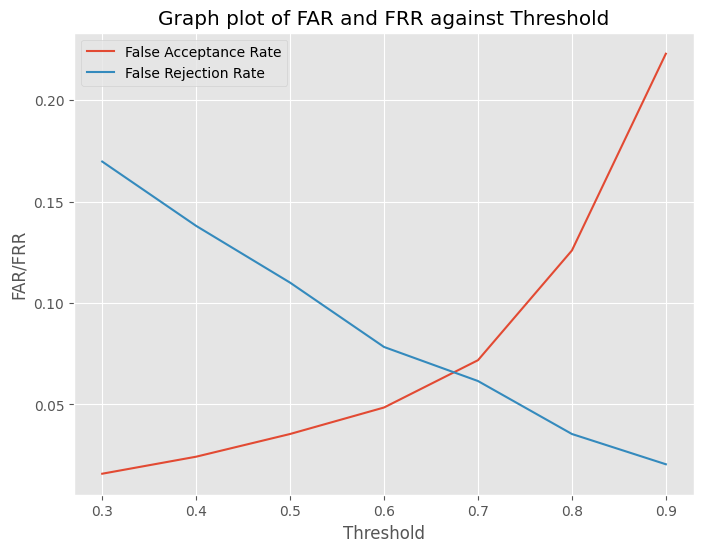

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, fars, label = 'False Acceptance Rate')
ax.plot(thresholds, frrs, label = 'False Rejection Rate')
ax.set_title("Graph plot of FAR and FRR against Threshold")
ax.set_xlabel('Threshold')
ax.set_ylabel('FAR/FRR')
ax.legend()
plt.show()

In [ ]:
# Find intersection points
idx = np.argwhere(np.diff(np.sign(np.array(fars) - np.array(frrs)))).flatten()
idx = idx[0]

# Get equal error rate by calc. FAR+FRR/2 for FAR and FRR that minimize abs(FAR-FRR); source: https://stats.stackexchange.com/questions/221562/calculate-eer-from-far-and-frr
eer = (fars[idx]+frrs[idx])/2
print("Equal error rate is: ", eer)
wandb.log(({f'EER': eer}))
wandb.log({"plot of FRR and FAR against thresholds": fig})

Equal error rate is:  0.06343283582089553


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Calculate new threshold using linear interpolation
new_thresh = thresholds[idx+1] - ((thresholds[idx+1] - thresholds[idx])*(fars[idx+1] - eer)/(fars[idx+1] - fars[idx]))
print('New Threshold is: ', new_thresh)

New Threshold is:  0.6639999999999999


In [ ]:
# Calculate new test accuraccy at equal error rate
pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
new_acc = compute_accuracy(te_y, pred_te, threshold=new_thresh)
print(f"New Test accuracy at equal error rate is: {new_acc}")
# Log the new test accuracy to wandb
wandb.log({f'Test Accuracy at EER': new_acc})

67/67 [==============================] - 0s 3ms/step
New Test accuracy at equal error rate is: 0.9347014925373134


In [ ]:
 # Plot the representation learned from the siamese network
embeddings = base_network.predict(x_train)

260/260 [==============================] - 1s 2ms/step


In [ ]:
# X_embedded = TSNE(n_components=3,random_state=0).fit_transform(embeddings)

In [ ]:
# cattle_classes = unique.tolist()

In [ ]:
# # Using the 'tab10' colormap
# colormap = plt.cm.get_cmap('tab10', num_classes)

# # Generate a list of distinct colors
# colors = [colormap(i) for i in range(num_classes)]

# # Print or use the colors as needed
# print(colors)

In [ ]:
# fig = plt.figure(figsize=(10,10))
# #ax = fig.add_subplot(111)
# ax = fig.add_subplot(111, projection='3d')
# for i in range(len(unique)):
#     inds = np.where(y_train==unique[i])[0]
#     ax.scatter(X_embedded[inds,0], X_embedded[inds,1], X_embedded[inds, 2] ,alpha=0.5, color=colors[i])
# plt.show()

In [ ]:
# wandb.log({"Clusters of classes in 3D": wandb.Image(fig)})

## Time for a single prediction

In [ ]:
import time

In [ ]:
x_test_time = x_test.copy()
x_train_time = x_train.copy()
x_train_time.shape

(8308, 50, 50)

In [ ]:
%%capture
np.random.seed(0)
start_time = time.time()
cattle_indices = [np.where(y_train == i)[0] for i in unique]
example_numbers = 1
example_indexes = [np.random.choice((cattle_indices[i]), example_numbers, replace=False) for i in range(len(cattle_indices))]
predictions =[]

image_sub = x_test[0].reshape(1,50,50)
pred_sum = []
for i in range(0,268):
    raw_prediction = []
    for exam in range(0,example_numbers):
        example_image = x_train[example_indexes[i][exam]].reshape(1,50,50)
        prd = np.squeeze(model.predict([image_sub,example_image]))
        raw_prediction.append(prd)
    pred_sum.append(sum(raw_prediction))
prediction = [np.argmin(pred_sum),min(pred_sum)]
end_time = time.time()

In [ ]:
print(f"Prediction time considering {example_numbers} samples for each class is: {end_time - start_time} seconds")

Prediction time considering 1 samples for each class is: 13.806514978408813 seconds


In [ ]:
y_test[0]

'0100'

In [ ]:
idx_pred = prediction[0]
unique[idx_pred]

'0100'

In [ ]:
wandb.finish()

EER,▁
Test Accuracy,▁
Test Accuracy at EER,▁
accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇█▇▇▇██▇███████▇████▇██▇████▆██████
val_loss,█▄▃▄▃▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▂▁▁▁▁▃▁▂▂▁▁▁▁▃▁▁▁▁▁▁
EER,0.06343
Test Accuracy,0.92724
Test Accuracy at EER,0.9347
